In [1]:
import datetime, math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers, layers
from tensorflow.keras.applications import InceptionResNetV2, InceptionV3, ResNet152V2, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, PReLU, LeakyReLU, Add, Activation, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, UpSampling2D, Input, Dropout, ZeroPadding2D, Concatenate

import os
file = os.environ['DRJIT_LIBLLVM_PATH']
print('file:',file,'exist:',os.path.exists(file))
import sionna as sn

from utils.datasets import get_dataset_from_directory
from utils.lr import lrStepScheduler

from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print(tf.__version__)

file: C:\Program Files\LLVM\bin\LLVM-C.dll exist: True
2.10.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: 
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Datasets

Found 150 files belonging to 1 classes.
Using 120 files for training.
length of dataset: 30
dataset image shape: (256, 256, 3)
Max pixel value: 1.0
Min pixel value: 0.0


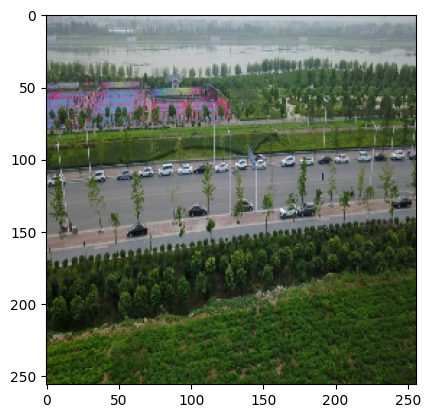

In [3]:
# Datasets
image_size = (256, 256)
input_shape = (256, 256, 3)
batch_size = 4
dataset_root = './datasets/Drone/VisDrone2019-DET-train/images'
train_ds, shape = get_dataset_from_directory(dataset_root, subset='training', show_spec=True, batch_size=batch_size, image_size = image_size)
    
# print(np.prod(shape))"

### Hyperparameters

In [4]:
# Hyperparameters

SNR_train_dB = [1, 4, 7, 13, 19]
# SNR_train_dB = [1, 19]
bandwidth_compression_ratio = [6, 12]
# bandwidth_compression_ratio = [6]
lr = 1e-4           # learning rate 조절 X -> 이 값 이하일 경우 Nan, Inf값 발생
num_epoch = 500     # 원래 1000

### Encoder

In [5]:
# Encoder ResNet152V2 이용(전이학습)

class jsccEncoder(layers.Layer):
    def __init__(self, shape, k, **kwargs):
        super(jsccEncoder, self).__init__(**kwargs)
        self.shape = shape
        self.k = k
        base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=shape)
        self.dropout = layers.Dropout(0.3)

        # 중간 레이어의 출력을 포함한 모델 생성

        self.encoder = Model(inputs=base_model.input, outputs=[
            base_model.get_layer("conv1_conv").output,                  # s1  128 X 128 X 64
            base_model.get_layer("conv2_block3_preact_relu").output,    # s2   64 X 64 X 256
            base_model.get_layer("conv3_block8_preact_relu").output,    # s3   32 X 32 X 512
            base_model.get_layer("conv4_block36_preact_relu").output,   # s4   16 X 16 X 1024
            base_model.get_layer("post_relu").output,                   # b    8 X 8 X 2048
        ])
        
        # Decoder Shape: 16 X 16 X 1024  ->  32 X 32 X 512  ->  64 X 64 X 256  ->  128 X 128 X 64

        # tanh 활성화 함수 적용하여 출력 범위 제한        Nan, Inf값 방지를 위한 Activation function -> 잘 사용하지 않음
        # self.tanh_activation = Activation('tanh')

        # self.Prelu_activation = Activation('PReLU')

    def call(self, inputs):
        # Encoder
        s1, s2, s3, s4, b = self.encoder(inputs)

        # Check each layer output
        self.check_nan_inf(s1, "After s1")
        self.check_nan_inf(s2, "After s2")
        self.check_nan_inf(s3, "After s3")
        self.check_nan_inf(s4, "After s4")
        self.check_nan_inf(b, "After b")

        # b = self.Prelu_activation(b)
 
        b = self.dropout(b)  # Apply dropout after encoding

        # Flatten the output to prepare for complex number conversion
        s1_flattened = tf.reshape(s1, (2, -1))     # Flattening
        s2_flattened = tf.reshape(s2, (2, -1))
        s3_flattened = tf.reshape(s3, (2, -1))
        s4_flattened = tf.reshape(s4, (2, -1))
        b_flattened = tf.reshape(b, (2, -1))
        # self.check_nan_inf(b_flattened, "After Flattening")

        # Modulization
        modulized_s1 = tf.complex(s1_flattened[0], s1_flattened[1])     # Modulization
        modulized_s2 = tf.complex(s2_flattened[0], s2_flattened[1])
        modulized_s3 = tf.complex(s3_flattened[0], s3_flattened[1])
        modulized_s4 = tf.complex(s4_flattened[0], s4_flattened[1])
        modulized_b = tf.complex(b_flattened[0], b_flattened[1])
        # self.check_nan_inf(modulized, "After Modulization")

        # Normalization
        s1_norm = self.encoderNormalizer(modulized_s1)
        s2_norm = self.encoderNormalizer(modulized_s2)
        s3_norm = self.encoderNormalizer(modulized_s3)
        s4_norm = self.encoderNormalizer(modulized_s4)
        norm_result = self.encoderNormalizer(modulized_b)
        # self.check_nan_inf(norm_result, "After Normalization")

        return s1_norm, s2_norm, s3_norm, s4_norm, norm_result

    # Normalization function 
    def encoderNormalizer(self, z):
        norm = tf.math.sqrt(tf.reduce_sum(tf.math.conj(z) * z))
        return z * math.sqrt(self.k) / norm # Assume power constraint is 1

    def check_nan_inf(self, tensor, message):
        real_part = tf.math.real(tensor) if tensor.dtype.is_complex else tensor
        imag_part = tf.math.imag(tensor) if tensor.dtype.is_complex else tensor
        
        if tf.reduce_any(tf.math.is_nan(real_part)) or tf.reduce_any(tf.math.is_nan(imag_part)):
            print(f"Warning: NaN in {message}")
        if tf.reduce_any(tf.math.is_inf(real_part)) or tf.reduce_any(tf.math.is_inf(imag_part)):
            print(f"Warning: Inf in {message}")

### Decoder

In [6]:
# Deocder

class jsccDecoder(layers.Layer):
    def __init__(self, filter):
        super().__init__()
        self.filter = int(filter)
        
        # decoder 1
        filter = filter/2
        self.trans_conv6 = layers.Conv2DTranspose(filter, (2, 2), 2, padding = "same")   # 16 X 16 X1024
        self.conv6 = layers.Conv2D(filter, 1, padding="same")
        self.batch6 = BatchNormalization()
        self.relu6 = layers.Activation("relu")
#         self.conv6_1 = layers.Conv2D(filter, 3, padding="same")
#         self.batch6_1 = BatchNormalization()
#         self.relu6_1 = layers.Activation("relu")

        # decoder 2
        filter = filter/2
        self.trans_conv5 = layers.Conv2DTranspose(filter, (2, 2), 2, padding = "same")   # 32 X 32 X 512
        self.conv5 = layers.Conv2D(filter, 1, padding="same")
        self.batch5 = BatchNormalization()
        self.relu5 = layers.Activation("relu")
#         self.conv5_1 = layers.Conv2D(filter, 3, padding="same")
#         self.batch5_1 = BatchNormalization()
#         self.relu5_1 = layers.Activation("relu")

        # decoder 3
        filter = filter/2
        self.trans_conv4 = layers.Conv2DTranspose(filter, (2, 2), 2, padding = "same")   # 64 X 64 X 256
        self.conv4 = layers.Conv2D(filter, 1, padding="same")
        self.batch4 = BatchNormalization()
        self.relu4 = layers.Activation("relu")
#         self.conv4_1 = layers.Conv2D(filter, 3, padding="same")
#         self.batch4_1 = BatchNormalization()
#         self.relu4_1 = layers.Activation("relu")

        # decoder 4
        filter = filter/4
        self.trans_conv3 = layers.Conv2DTranspose(filter, (2, 2), 2, padding = "same")   # 128 X 128 X 64
        self.conv3 = layers.Conv2D(filter, 1, padding="same")
        self.batch3 = BatchNormalization()
        self.relu3 = layers.Activation("relu")
#         self.conv3_1 = layers.Conv2D(filter, 3, padding="same")
#         self.batch3_1 = BatchNormalization()
#         self.relu3_1 = layers.Activation("relu")

        # decoder 5
        filter = filter/2
        self.trans_conv2 = layers.Conv2DTranspose(filter, (2, 2), 2, padding = "same")   # 256 X 256 X 32
        self.conv2 = layers.Conv2D(filter, 1, padding="same")
        self.batch2 = BatchNormalization()
        self.relu2 = layers.Activation("relu")
#         self.conv2_1 = layers.Conv2D(filter, 3, padding="same")
#         self.batch2_1 = BatchNormalization()
#         self.relu2_1 = layers.Activation("relu")

        self.dropout = layers.Dropout(0.3)

        # ------------------------------------------------
        # 활성화 함수 Nan, Inf 값 출력 여부 확인 코드
        # self.relu6 = CustomActivationLayer()
        # self.relu5 = CustomActivationLayer()
        # self.relu4 = CustomActivationLayer()
        # self.relu3 = CustomActivationLayer()
        # self.relu2 = CustomActivationLayer()
        # ------------------------------------------------

        self.sigmoid = layers.Conv2D(3, 1, padding="same", activation="sigmoid")

    def call(self, s1, s2, s3, s4, encoded):
        # Calculate the number of features for each real and imaginary part
        
        # Reshape 구간
        feature_dim_s4 = (tf.shape(s4)[0] // (batch_size * 16 * 16)) * 2

        # Separate real and imaginary parts
        real_part = tf.math.real(s4)
        imag_part = tf.math.imag(s4)

        # 실수 부분과 허수 부분을 채널 차원에서 결합
        s4 = tf.concat([real_part, imag_part], axis=0)

        # Reshape to the appropriate shape, considering the batch size and feature dimension
        s4 = tf.reshape(s4, [batch_size, 16, 16, feature_dim_s4])

        #############
        feature_dim_s3 = (tf.shape(s3)[0] // (batch_size * 32 * 32)) * 2

        # Separate real and imaginary parts
        real_part = tf.math.real(s3)
        imag_part = tf.math.imag(s3)

        # 실수 부분과 허수 부분을 채널 차원에서 결합
        s3 = tf.concat([real_part, imag_part], axis=0)

        # Reshape to the appropriate shape, considering the batch size and feature dimension
        s3 = tf.reshape(s3, [batch_size, 32, 32, feature_dim_s3])
        
        ##############
        feature_dim_s2 = (tf.shape(s2)[0] // (batch_size * 64 * 64)) * 2

        # Separate real and imaginary parts
        real_part = tf.math.real(s2)
        imag_part = tf.math.imag(s2)

        # 실수 부분과 허수 부분을 채널 차원에서 결합
        s2 = tf.concat([real_part, imag_part], axis=0)

        # Reshape to the appropriate shape, considering the batch size and feature dimension
        s2 = tf.reshape(s2, [batch_size, 64, 64, feature_dim_s2])
        
        #############
        feature_dim_s1 = (tf.shape(s1)[0] // (batch_size * 128 * 128)) * 2

        # Separate real and imaginary parts
        real_part = tf.math.real(s1)
        imag_part = tf.math.imag(s1)

        # 실수 부분과 허수 부분을 채널 차원에서 결합
        s1 = tf.concat([real_part, imag_part], axis=0)

        # Reshape to the appropriate shape, considering the batch size and feature dimension
        s1 = tf.reshape(s1, [batch_size, 128, 128, feature_dim_s1])
        
        #############
        feature_dim = (tf.shape(encoded)[0] // (batch_size * 8 * 8)) * 2

        # Separate real and imaginary parts
        real_part = tf.math.real(encoded)
        imag_part = tf.math.imag(encoded)

        # 실수 부분과 허수 부분을 채널 차원에서 결합
        x = tf.concat([real_part, imag_part], axis=0)

        # Reshape to the appropriate shape, considering the batch size and feature dimension
        x = tf.reshape(x, [batch_size, 8, 8, feature_dim])
        
        #############

        # decoder 1
        x = self.trans_conv6(x)
        # tf.print("Shape after trans_conv6:", tf.shape(x))
        x = Concatenate()([x, s4])
        x = self.conv6(x)
        # tf.print("Shape after conv6:", tf.shape(x))
        x = self.batch6(x)
        # tf.print("Shape after batch6:", tf.shape(x))
        x = self.relu6(x)
        # tf.print("Shape after relu6:", tf.shape(x))
#         x = self.conv6_1(x)
#         # tf.print("Shape after conv6_1:", tf.shape(x))
#         x = self.batch6_1(x)
#         # tf.print("Shape after batch6_1:", tf.shape(x))
#         x = self.relu6_1(x)
#         # tf.print("Shape after relu6_1:", tf.shape(x))

        # decoder 2
        x = self.trans_conv5(x)
        x = Concatenate()([x, s3])
        x = self.conv5(x)
        x = self.batch5(x)
        x = self.relu5(x)
#         x = self.conv5_1(x)
#         x = self.batch5_1(x)
#         x = self.relu5_1(x)

        # decoder 3
        x = self.trans_conv4(x)
        x = Concatenate()([x, s2])
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.relu4(x)
#         x = self.conv4_1(x)
#         x = self.batch4_1(x)
#         x = self.relu4_1(x)

        # decoder 4
        x = self.trans_conv3(x)
        x = Concatenate()([x, s1])
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu3(x)
#         x = self.conv3_1(x)
#         x = self.batch3_1(x)
#         x = self.relu3_1(x)

        # decoder 5
        x = self.trans_conv2(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
#         x = self.conv2_1(x)
#         x = self.batch2_1(x)
#         x = self.relu2_1(x)

        # dropout
        x = self.dropout(x)

        x = self.sigmoid(x)
        # x = x * 255             # Normalizing range [0, 256] into [0, 1]

        return x

## Model(All System)

### Error Correction Code

In [7]:
# Encoder(Flatten + Modulation + Normalization) -> noise + AWGN Channel -> Decoder

class jsccSystem(Model):
    def __init__(self, shape, bw, SNR):
        
        """
        jsccSystem 클래스 초기화
        :param shape: 입력 데이터의 형태
        :param bw: 대역폭 압축 비율
        :param SNR_dB: 신호 대 잡음비(dB 단위)
        """
        
        super(jsccSystem, self).__init__()
        k = np.prod(shape) * bw  # 전체 데이터 비트 수 계산

        self.noise = sn.utils.ebnodb2no(SNR, num_bits_per_symbol=1, coderate=1)
        self.encoder = jsccEncoder(shape, k)
        self.channel = sn.channel.AWGN()
        self.decoder = jsccDecoder(2048)

    def call(self, inputs):
        """
        모델 실행: 입력 데이터를 인코딩, 채널 통과 및 디코딩
        :param inputs: 입력 데이터
        :return: 디코딩된 신호
        """

        s1, s2, s3, s4, z = self.encoder(inputs)
        
        s1_hat = self.channel([s1, self.noise])
        s2_hat = self.channel([s2, self.noise])
        s3_hat = self.channel([s3, self.noise])
        s4_hat = self.channel([s4, self.noise])
        z_hat = self.channel([z, self.noise])
        
        # print("After AWGN Channel:", z_hat)
        
        x_hat = self.decoder(s1_hat, s2_hat, s3_hat, s4_hat, z_hat)
        
        return x_hat

## Training

In [8]:
# training(훈련잘 되는지 확인하는 코드)마다 이미지 생성 함수

def display_images(epoch, model, dataset):
    # 배치에서 첫 번째 이미지를 선택합니다
    for images_batch in dataset.take(1):
        # original_image = images_batch[0].numpy().astype(np.uint8)

        original_image = images_batch[0].numpy()
        # original_image_uint8 = (original_image * 255).astype(np.uint8)

        transmitted_image = model(images_batch, training=False)[0].numpy()
        # transmitted_image_uint8 = (transmitted_image * 255).astype(np.uint8)


        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f"Epoch {epoch + 1} - Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(transmitted_image)
        plt.title(f"Epoch {epoch + 1} - Transmitted Image")
        plt.axis('off')
        plt.show()

In [ ]:
# Training

best_ssim = 0             # SSIM을 추적하기 위한 변수
patience = 10             # 조기 종료를 위한 인내심 (예를 들어, 10 에포크 동안 개선이 없으면 종료)

for BW in bandwidth_compression_ratio:
    for SNR in SNR_train_dB:
        log_dir = f'./logs/ChangedDataset/BW{BW}_{SNR}dB'
        summary_writer = tf.summary.create_file_writer(log_dir)          # 가중치 저장
        model = jsccSystem(input_shape, 1/BW, SNR)                       # 모델 선언
        mse_loss = tf.keras.losses.MeanSquaredError()                    # loss function 적용 -> MSE loss function으로 적용
        mae_loss = tf.keras.losses.MeanAbsoluteError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)           # optimizer 설정
        
        wait = 0                                                         # 개선이 없을 때까지 기다린 에포크 수
        best_loss = float('inf')                                         # 최고 손실값을 무한대로 초기화
        best_loss2 = float('inf')

        for i in tqdm(range(num_epoch)):
            losses = []              # mse loss
            losses2 = []             # mae loss
            PSNRs = []
            SSIMs = []  # SSIM 값 저장을 위한 리스트
            
            for step, image_batch in enumerate(train_ds):
                # 이미지 배치를 시각적으로 확인
                if i == 0 and step == 0:                                # 첫 번째 에포크의 첫 번째 스텝에서만 시각화
                    plt.figure(figsize=(10, 10))
                    for j in range(min(batch_size, 4)):                 # 배치의 첫 4개 이미지만 출력
                        ax = plt.subplot(1, 4, j + 1)
                        plt.imshow(image_batch[j].numpy())
                        plt.title(f"Batch {step}, Image {j}")
                        plt.axis("off")
                    plt.show()
                    
                # Forward
                with tf.GradientTape() as tape:
                    output = model(image_batch)
                    loss = mse_loss(image_batch, output)         # mse loss
                    loss2 = mae_loss(image_batch, output)        # mae loss
                                 
                # Backward
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                                 
                # Accuracy
                losses.append(loss)                              # mse loss
                losses2.append(loss2)                            # mae loss
                PSNRs.append(tf.image.psnr(image_batch, output, max_val=1))
                SSIMs.append(tf.image.ssim(image_batch, output, max_val=1).numpy().mean())

            # 평균 손실과 PSNR 계산
            avg_loss = np.mean(losses)                           # mse loss
            avg_loss2 = np.mean(losses2)                         # mae loss
            avg_psnr = np.mean(PSNRs)
            avg_ssim = np.mean(SSIMs)

            display_images(i, model, train_ds)
            
            # Check for improvement and implement early stopping
#             if (avg_loss < best_loss) or (avg_loss2 < best_loss2):
#                 if (avg_loss < best_loss):
#                     best_loss = avg_loss
#                 elif (avg_loss2 < best_loss2):
#                     best_loss2 = avg_loss2
#                 model.save_weights(f'{log_dir}/weights')
#                 # Garbage collection
#                 gc.collect()
#                 tf.keras.backend.clear_session()
#                 wait = 0
#             else:
#                 wait += 1
#                 if wait >= patience:
#                     print(f"Early stopping triggered at epoch {i+1}.")
#                     break
                    
            model.save_weights(f'{log_dir}/weights')
                    
            # 현재 epoch의 손실과 PSNR 출력
            print(f'epoch {i+1}/{num_epoch}, SNR: {SNR}, MSE Loss: {avg_loss:.4f}, MAE Loss: {avg_loss2:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}')

            # Log to TensorBoard
            with summary_writer.as_default():
                tf.summary.scalar('average loss(MSE)', avg_loss, i+1)
                tf.summary.scalar('average loss2(MAE)', avg_loss, i+1)
                tf.summary.scalar('average PSNR', avg_psnr, i+1)
                tf.summary.scalar('average SSIM', avg_ssim, i+1)

## Test

In [8]:
# test(결과 출력)마다 이미지 생성 함수

def display_images_test(epoch, SNR, model, dataset):
    # 배치에서 첫 번째 이미지를 선택합니다
    for images_batch in dataset.take(1):
        # original_image = images_batch[0].numpy().astype(np.uint8)

        original_image = images_batch[0].numpy()
        # original_image_uint8 = (original_image * 255).astype(np.uint8)

        transmitted_image = model(images_batch, training=False)[0].numpy()
        # transmitted_image_uint8 = (transmitted_image * 255).astype(np.uint8)


        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(transmitted_image)
        plt.title(f"Existing Recovered images after transfer")
        plt.axis('off')
        # plt.show()

Found 4 files belonging to 1 classes.
Using 0 files for validation.
length of dataset: 1
dataset image shape: (256, 256, 3)
Max pixel value: 0.9994207620620728
Min pixel value: 0.0


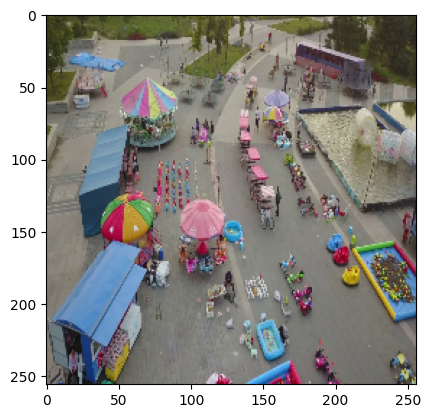

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.89s/it]
C:\Users\Owner\AppData\Local\Temp\ipykernel_41068\3005867109.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_data], ignore_index=True)


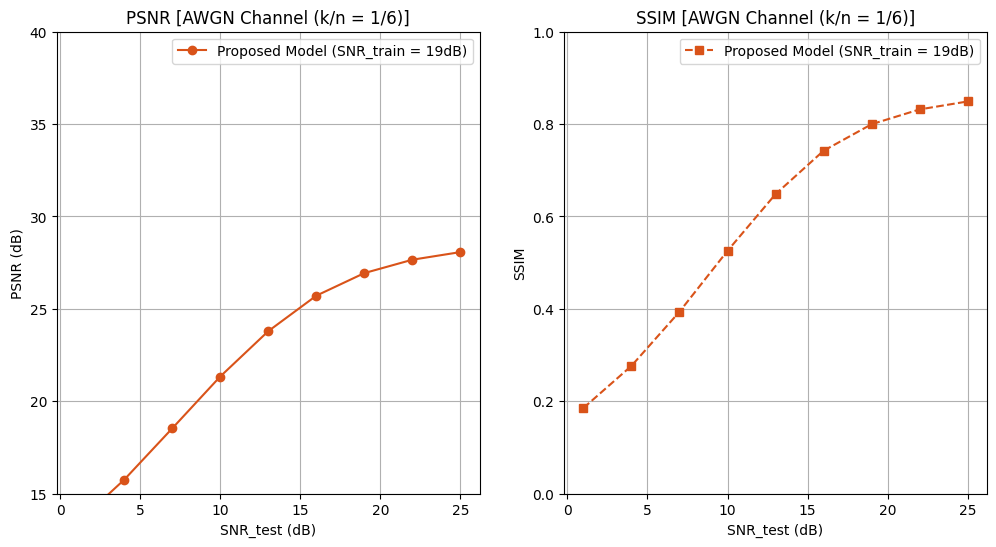

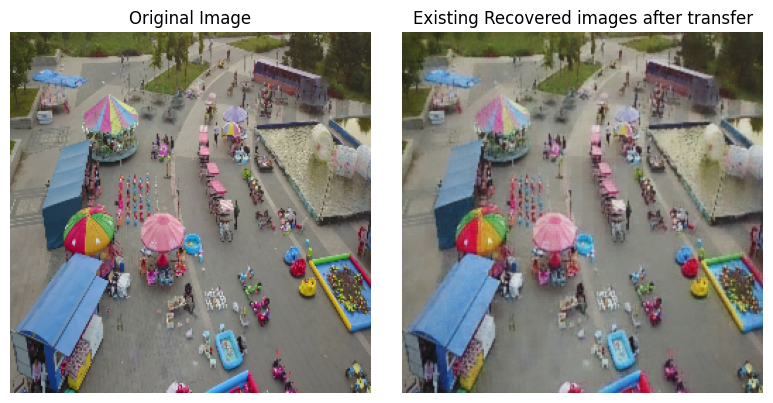

In [31]:
# Test

def save_image(decoded, train_SNR, test_SNR):
    decoded_image = tf.image.convert_image_dtype(decoded, dtype=tf.uint8)

    # original_path = os.path.join(image_save_dir, f'original_trainSNR{train_SNR}_testSNR{test_SNR}_idx{idx}.png')
    decoded_path = os.path.join(image_save_dir, f'decoded_trainSNR{train_SNR}_testSNR{test_SNR}.png')

    # tf.keras.preprocessing.image.save_img(original_path, original_image[0])
    tf.keras.preprocessing.image.save_img(decoded_path, decoded_image[0])
    
dataset_root = './datasets/Drone/VisDrone2019-DET-test/images'
test_ds, shape = get_dataset_from_directory(dataset_root, subset='validation', batch_size=4, image_size=(256, 256))

BW = 6
train_SNRs = [19]
plot_color = ['#d95319', '#edb120', '#77ac30', '#0072bd', '#7e2f8e']
plot_marker = ['-o'] * len(train_SNRs)
test_SNRs = [1, 4, 7, 10, 13, 16, 19 ,22, 25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 손실 함수 초기화
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

# 데이터를 저장할 DataFrame을 초기화
results_df = pd.DataFrame(columns=['Train SNR', 'Test SNRs', 'Average PSNR', 'Average SSIM', 'Average MSE Loss', 'Average MAE Loss'])

# 이미지 저장 디렉토리 설정
image_save_dir = './logs/ChangedDataset/results'
os.makedirs(image_save_dir, exist_ok=True)

for i, train_SNR in enumerate(train_SNRs):
    model_dir = f'./logs/ChangedDataset/BW{BW}_{train_SNR}dB/weights'
    avg_PSNR = []
    avg_SSIM = []
    avg_mse_losses = []
    avg_mae_losses = []

    for test_SNR in tqdm(test_SNRs):
        test_model = jsccSystem(input_shape, 1/BW, test_SNR)
        test_model.load_weights(model_dir)
        PSNRs = []
        SSIMs = []
        mse_losses = []
        mae_losses = []
        for image in test_ds:
            output = test_model(image)
            mse_losses.append(mse_loss(image, output).numpy())
            mae_losses.append(mae_loss(image, output).numpy())
            PSNRs.append(tf.image.psnr(image, output, max_val=1))
            SSIMs.append(tf.image.ssim(image, output, max_val=1))
            
        # 이미지를 저장
        save_image(output, train_SNR, test_SNR)
            
        avg_mse_losses.append(np.mean(mse_losses))
        avg_mae_losses.append(np.mean(mae_losses))
        avg_PSNR.append(np.mean(PSNRs))
        avg_SSIM.append(np.mean(SSIMs))
            
    # 결과 DataFrame에 데이터 추가
    new_data = pd.DataFrame({
        'Train SNR': [train_SNR] * len(test_SNRs),
        'Test SNRs': test_SNRs,
        'Average PSNR': avg_PSNR,
        'Average SSIM': avg_SSIM,
        'Average MSE Loss': avg_mse_losses,
        'Average MAE Loss': avg_mae_losses
    })
    
    # 결측치를 0 또는 다른 적절한 값으로 채우기
    new_data.fillna(0, inplace=True)

    results_df = pd.concat([results_df, new_data], ignore_index=True)
    
            # 여기서 각 테스트 SNR에 대한 평균 PSNR 값을 출력합니다.
            # print(f'Train SNR: {train_SNR}dB, Test SNR: {test_SNR}dB, Average PSNR: {avg_PSNR:.2f}dB, Average SSIM: {avg_SSIM:.2f}')
            
    # PSNR plot
    ax1.set_title(f'PSNR [AWGN Channel (k/n = 1/{BW})]')
    ax1.set_xlabel('SNR_test (dB)')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_ylim([15, 40])
    ax1.plot(test_SNRs, avg_PSNR, 'o-', color=plot_color[i], label=f'Proposed Model (SNR_train = {train_SNR}dB)')
    ax1.legend()
    ax1.grid(True)

    # SSIM plot
    ax2.set_title(f'SSIM [AWGN Channel (k/n = 1/{BW})]')
    ax2.set_xlabel('SNR_test (dB)')
    ax2.set_ylabel('SSIM')
    ax2.set_ylim([0, 1])
    ax2.plot(test_SNRs, avg_SSIM, 's--', color=plot_color[i], label=f'Proposed Model (SNR_train = {train_SNR}dB)')
    ax2.legend()
    ax2.grid(True)
    
    display_images_test(i, train_SNR, test_model, test_ds)


# 결과 DataFrame에 데이터 추가
results_df.to_excel('./logs/ChangedDataset/test_results.xlsx', index=False)

plt.tight_layout()
plt.show()